In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 5.1 MB/s 
     |████████████████████████████████| 245 kB 55.9 MB/s 
     |████████████████████████████████| 727 kB 35.6 MB/s 
     |████████████████████████████████| 152 kB 74.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fga = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Polymer_Solution_Cloud_Point_FGA.csv")

In [5]:
fga.tail()

,Unnamed: 0,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),CP,1-Phase
4828,4828,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.44220,0.5056,0.1,63.14,negative
4829,4829,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.09225,0.1159,0.1,71.08,negative
4830,4830,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.11156,0.1394,0.1,72.63,negative
4831,4831,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.34850,0.4083,0.1,73.50,negative
4832,4832,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.26001,0.3119,0.1,73.50,negative


In [6]:
fga = fga.drop("Unnamed: 0", axis=1)

In [7]:
#Move CP column to the end
fga_cp = fga["CP"]
f = fga.drop("CP",axis=1)
f["CP"] = fga_cp
f.head()

,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,fr_oxime_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),1-Phase,CP
0,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,0,0,1,0,0,10,0,0,0,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,0,0,1,0,0,10,0,0,0,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,0,0,1,0,0,10,0,0,0,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08


In [8]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(f["1-Phase"])

f["1-Phase"] = LE.fit_transform(f["1-Phase"])
f

,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,fr_oxime_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),1-Phase,CP
0,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,0,0,1,0,0,10,0,0,0,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,0,0,1,0,0,10,0,0,0,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,0,0,1,0,0,10,0,0,0,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = f.copy()
# f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP"]] = scaler.fit_transform(f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP"]])
f_std.iloc[:, :-1] = scaler.fit_transform(f_std.iloc[:, :-1])

In [13]:
f_std.head()

,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,fr_oxime_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),1-Phase,CP
0,0.749367,0.0,0.0,0.749367,-0.278122,-0.500371,0.327082,0.0,0.0,0.0,...,-0.043193,0.0,0.0,-0.531646,-0.548048,0.036676,0.145899,5.774263,0.782696,21.34
1,0.749367,0.0,0.0,0.749367,-0.278122,-0.500371,0.327082,0.0,0.0,0.0,...,-0.043193,0.0,0.0,-0.531646,-0.548048,0.657195,0.846006,5.564014,0.782696,21.18
2,0.749367,0.0,0.0,0.749367,-0.278122,-0.500371,0.327082,0.0,0.0,0.0,...,-0.043193,0.0,0.0,-0.323328,-0.484995,-0.947929,-1.050794,-0.414228,0.782696,73.99
3,0.749367,0.0,0.0,0.749367,-0.278122,-0.500371,0.327082,0.0,0.0,0.0,...,-0.043193,0.0,0.0,-0.516014,-0.579574,0.036219,0.171004,-0.345393,0.782696,27.42
4,0.749367,0.0,0.0,0.749367,-0.278122,-0.500371,0.327082,0.0,0.0,0.0,...,-0.043193,0.0,0.0,-0.545239,-0.548048,0.638369,0.396117,-0.096237,0.782696,6.08


# **Model Building**

In [14]:
from sklearn.model_selection import train_test_split

X = f_std.iloc[:, :-1].values
y = f_std.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [15]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Lasso

In [16]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.182e+03, tolerance: 2.318e+03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8074058958754329
RMSE(Train): 33.98045783614836

R_square(Test): 0.8215857299708631
RMSE(Test): 32.1691823348025


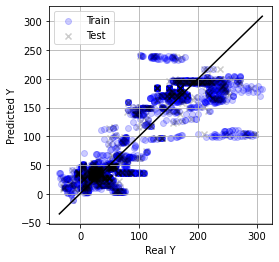

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [19]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Lasso)'] = [R_square_train, R_square_test] 

## Ridge

In [20]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8188450997935437
RMSE(Train): 32.95586955113132

R_square(Test): 0.8258973513046772
RMSE(Test): 31.77809929538928


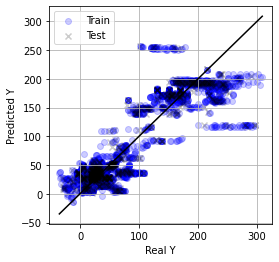

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [23]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Ridge)'] = [R_square_train, R_square_test] 

## ElasticNet

In [24]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.7793146807555276
RMSE(Train): 36.374284034894295

R_square(Test): 0.7962692192642135
RMSE(Test): 34.37585852563145


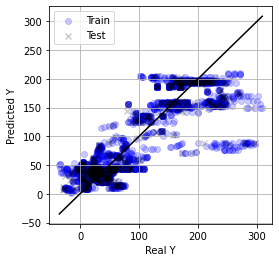

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [27]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(ElasticNet)'] = [R_square_train, R_square_test] 

## RF

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9994796433921218
RMSE(Train): 1.7662747848304101

R_square(Test): 0.9974518508601361
RMSE(Test): 3.844480391336619


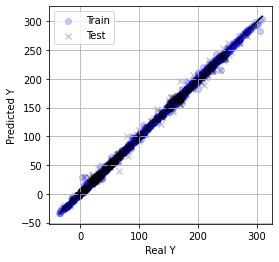

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [31]:
rmse_sum['RF'] = [RMSE_train, RMSE_test]
r2_sum['RF'] = [R_square_train, R_square_test] 

## SVR

In [32]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [33]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [34]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [35]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## XGB

In [36]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [37]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [38]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [39]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test] 
# r2_sum['XGBoost'] = [R_square_train, R_square_test] 

## GpyTorch

In [40]:
# from sklearn.preprocessing import MinMaxScaler,StandardScaler

# # X must be in the range=(0, 1)
# # use MinMaxScaler to transform features
# mmscaler = MinMaxScaler()
# X_train_mm = mmscaler.fit_transform(X_train)
# X_test_mm = mmscaler.transform(X_test)


# X_train_tensor = torch.from_numpy(np.array(X_train_mm))
# X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# # Y must be in the range=(-1, 1)
# y_scaler = StandardScaler()

# y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
# y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

# y_train_tensor = torch.from_numpy(np.array(y_train_s))
# y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [41]:
# kernel = RBFKernel(ard_num_dims=X.shape[1])

# gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# fit_gpytorch_model(mll)

In [42]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
# y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

# y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
# y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

# R_square_train = r2_score(y_train_s, y_train_pred)
# RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
# R_square_test = r2_score(y_test_s, y_test_pred)
# RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [43]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [44]:
# rmse_sum['GP'] = [RMSE_train, RMSE_test] 
# r2_sum['GP'] = [R_square_train, R_square_test] 

# **Summary**

In [45]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF
Train,33.980458,32.955870,36.374284,1.766275
Test,32.169182,31.778099,34.375859,3.844480


In [46]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF
Train,0.807406,0.818845,0.779315,0.999480
Test,0.821586,0.825897,0.796269,0.997452


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

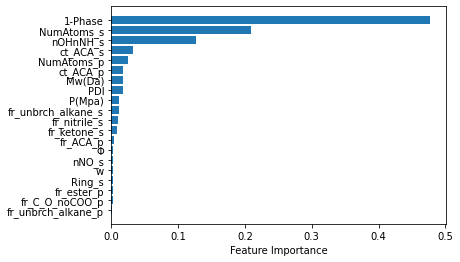

In [47]:
sort = rf.feature_importances_.argsort()
plt.barh(f.iloc[:, :-1].columns[sort].astype(str)[-20:], rf.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


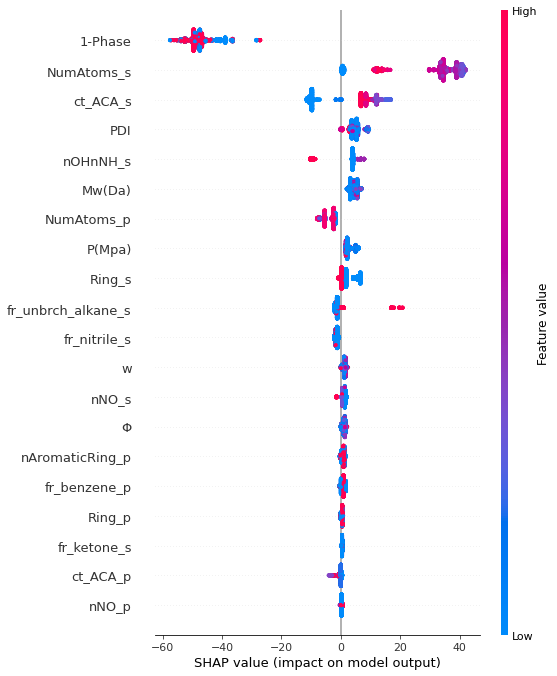

In [48]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f.iloc[:, :-1])
shap.summary_plot(shap_values, f.iloc[:, :-1])